# LSVT Exploration and Modeling

### Synopsis

This notebook is intended to illustare and compare several feature selection strategies on the [LSVT dataset](https://archive.ics.uci.edu/ml/datasets/LSVT+Voice+Rehabilitation). First, we will provide a simple exploratory analysis and then compare several feature selection strategies.

### Contents

1. [Exploration](#explore)
2. [Ridge Regression and LASSO](#ridge_lasso)
3. [Forward Feature Selection](#forward)
4. [Selection by ensemble of trees](#tree)


In [2]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
from itertools import product, combinations
import warnings

# sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, log_loss
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Selectors
from utils.selectors import *

warnings.simplefilter('ignore')

%matplotlib inline

# Setup Seaborn
sns.set(rc={"figure.figsize": (10, 8), "font.size": 12})
sns.set_style("white")
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})

Read data and assign labels:

In [3]:
dat = pd.read_excel('./data/LSVT_voice_rehabilitation.xlsx', sheet_name='Data')
Y = pd.read_excel('./data/LSVT_voice_rehabilitation.xlsx', sheet_name='Binary response')

# Change 1/2 to 1/0 (1=acceptable, 0=unacceptable)
Y = np.array(Y % 2).squeeze()

# Feature names
feat_names = dat.columns.tolist()

## Univariate analysis and visualization <a class="anchor" id="explore"></a>

Let's compute effect sizes and p-values to visualize all the features at the same time:

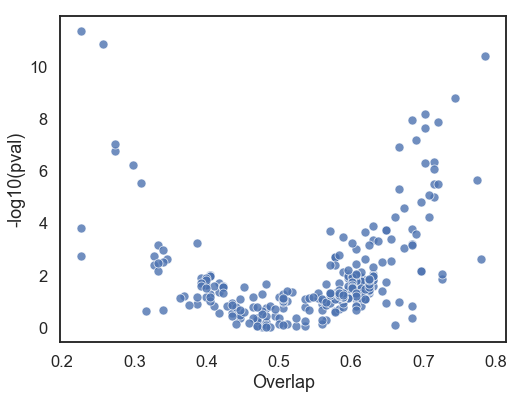

In [4]:
# Effect sizes and p-values from all data
simple_feat_names = ['f-' + str(i+1) for i in range(len(feat_names))] # Original names long
df_all = pd.DataFrame(dat.values, columns=simple_feat_names)
df_all['label'] = Y

df_v = volcano(df_all)

fig = plt.figure(figsize=(8,6))
df_v['log10p'] = df_v['pval'].apply(lambda x: -np.log10(x))

sns.scatterplot(data=df_v, x='mc_rate', y='log10p', alpha=0.8)
plt.xlabel('Overlap')
plt.ylabel('-log10(pval)')
plt.show()

Best features: Top left

In [5]:
mask = (df_v['log10p'] > 2) & (df_v['mc_rate'] < 0.3)
df_v[mask]

,pval,mc_rate,log10p
f-10,1.523989e-04,0.226190,3.817018
f-11,1.778417e-03,0.226190,2.749966
f-60,5.517370e-07,0.297619,6.258268
f-80,1.691941e-07,0.273810,6.771615
f-82,9.204856e-08,0.273810,7.035983
f-85,4.005041e-12,0.226190,11.397393
f-86,1.212460e-11,0.255952,10.916333


Let's go back to the original feature names:

In [6]:
temp = df_v[mask].index.tolist()
best_feats = [feat_names[int(s[-2:])-1] for s in temp]
print("Best features:")
print('\n'.join(best_feats))

Best features:
Jitter->F0_TKEO_prc5
Jitter->F0_TKEO_prc25
DFA
IMF->NSR_SEO
IMF->NSR_entropy
MFCC_1st coef
MFCC_2nd coef


Compare these with the best features identified in:

*
A. Tsanas, M.A. Little, C. Fox, L.O. Ramig: Objective automatic assessment of rehabilitative speech treatment in Parkinson's diseaseae, IEEE Transactions on Neural Systems and Rehabilitation Engineering, Vol. 22, pp. 181-190, January 2014 
*

## Feature selection and modeling 

In [7]:
# Data normalization
def standardize(X_tr, X_ts):
    # Compute mean and std of training set
    mu = np.mean(X_tr, axis=0)
    s = np.std(X_tr, axis=0)
    
    X_tr_new = (X_tr - mu) / s
    X_ts_new = (X_ts - mu) / s
    
    return X_tr_new, X_ts_new


# Train/test split
X_tr, X_ts, y_tr, y_ts = train_test_split(dat.values, Y, test_size=0.33, stratify=Y, random_state=12345)

# Standardize
X_tr_std, X_ts_std = standardize(X_tr, X_ts)

# As dataframe
df_tr = pd.DataFrame(X_tr_std, columns=simple_feat_names)
df_tr['label'] = y_tr
df_ts = pd.DataFrame(X_ts_std, columns=simple_feat_names)
df_ts['label'] = y_ts

## Ridge Regression and LASSO <a class="anchor" id="ridge_lasso"></a>

In [8]:
# Ridge Regression (penatly='l2') training
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state=12345)
clf_cv = LogisticRegressionCV(Cs = np.logspace(-4,1,20), cv = skf, penalty='l2', scoring = 'neg_log_loss',
                             n_jobs=-1)

clf_cv.fit(X_tr_std, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a1fcfff60>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
# Predictions (train/test)
y_prob_tr = clf_cv.predict_proba(X_tr_std)
y_prob_ts = clf_cv.predict_proba(X_ts_std)

In [10]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.2190 :: Test NLL = -0.3284
Train AUC = 0.9930 :: Test AUC = 0.9311


Effective degrees of freedom:

In [11]:
# Effective d.o.f
C_ = clf_cv.C_[0]
lam_ = 1.0 / C_
n_feats = X_tr_std.shape[1]

df_ridge = np.dot(np.dot(X_tr_std, np.linalg.inv(np.dot(X_tr_std.T, X_tr_std) + lam_*np.eye(n_feats))), X_tr_std.T).trace()

print("Ridge Regression effective d.o.f = {:.2f}".format(df_ridge))

Ridge Regression effective d.o.f = 47.97


In [12]:
print("Best C = {:.6f}".format(C_))

Best C = 0.042813


In [13]:
weights_ridge = np.squeeze(clf_cv.coef_)

In [14]:
# LASSO (penatly='l1') training
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state=12345)
clf_cv = LogisticRegressionCV(Cs = np.logspace(-4,1,20), cv = skf, penalty='l1', scoring = 'neg_log_loss',
                             solver='liblinear', n_jobs=-1)

clf_cv.fit(X_tr_std, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a20016240>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [15]:
# Predictions (train/test)
y_prob_tr = clf_cv.predict_proba(X_tr_std)
y_prob_ts = clf_cv.predict_proba(X_ts_std)

In [16]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.1782 :: Test NLL = -0.2959
Train AUC = 0.9987 :: Test AUC = 0.9337


Number of LASSO features:

In [17]:
weights_lasso = np.squeeze(clf_cv.coef_)
mask = weights_lasso != 0
print("Number of selected features = ", np.sum(mask))

Number of selected features =  19


In [18]:
print("Best C = {:.6f}".format(clf_cv.C_[0]))

Best C = 0.483293


## Forward feature selection <a class="anchor" id="forward"></a>

In [ ]:
rep_ridge = forward_select_ridge(df_tr, simple_feat_names, Cs = np.logspace(-4,1,20), 
                                 n_repeats = 5, n_splits=10, n_max=25)

Looks like we hit a local minima at C. Most likely, we will overfit..

In [21]:
nlls_forward = [sc for f,c,sc in rep_ridge]
feat_lists = [f for f,c,sc in rep_ridge]

idx_best = np.argmax(nlls_forward)
selected_features_forward = feat_lists[idx_best]
print("{:d}/{:d} features chosen".format(len(selected_features_forward),n_feats))

22/310 features chosen


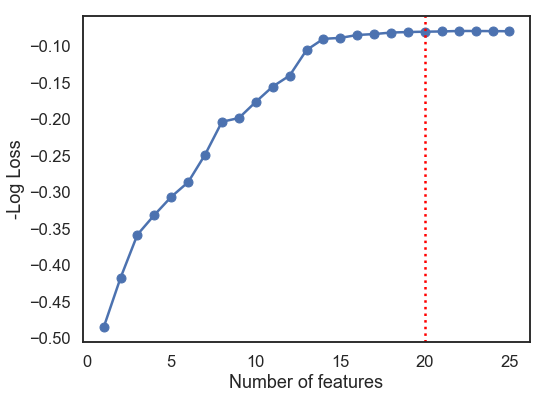

In [24]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(1,26), nlls_forward, 'b-o')
plt.axvline(20, color='red', linestyle = ':')
plt.xlabel('Number of features')
plt.ylabel('-Log Loss')
plt.show()

In [25]:
# Refit using best hyper-parameters
f_list_sk, c_best, _ = rep_ridge[idx_best]

xx_tr = df_tr[f_list_sk]
xx_ts = df_ts[f_list_sk]
clf_fin = LogisticRegression(C=c_best, penalty='l2')
clf_fin.fit(xx_tr, y_tr)

# Predict
y_prob_tr = clf_fin.predict_proba(xx_tr)
y_prob_ts = clf_fin.predict_proba(xx_ts)

In [26]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.0262 :: Test NLL = -0.7882
Train AUC = 1.0000 :: Test AUC = 0.8801


In [27]:
# Forward selection weights
weights_forward = np.squeeze(clf_fin.coef_)

This clearly shows that our greedy approach, even though supported by cross-validation, have resulted in overfitting.

## Tree ensembles <a class="anchor" id="tree"></a>

In [19]:
# Random Forest for Feature selection
rf = RandomForestClassifier(n_estimators=500, max_features=10, n_jobs=-1, random_state=12345)
rf.fit(X_tr_std, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [20]:
# Select features
selector = SelectFromModel(rf, prefit=True)
X_tr_new = selector.transform(X_tr_std)
X_ts_new = selector.transform(X_ts_std)

mask = list(selector.get_support())
selected_features_rf = [f for i,f in enumerate(range(n_feats)) if mask[i] == True]
selected_features_rf = list(map(lambda x: 'f-' + str(x), selected_features_rf))
print("Number of selected features = {:d}".format(len(selected_features_rf)))

Number of selected features = 89


In [21]:
skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=12345)
clf = LogisticRegressionCV(Cs = np.logspace(-1,4,20), penalty='l2', cv=skf, scoring='neg_log_loss', n_jobs=-1)
clf.fit(X_tr_new, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-01, 1.83298e-01, 3.35982e-01, 6.15848e-01, 1.12884e+00,
       2.06914e+00, 3.79269e+00, 6.95193e+00, 1.27427e+01, 2.33572e+01,
       4.28133e+01, 7.84760e+01, 1.43845e+02, 2.63665e+02, 4.83293e+02,
       8.85867e+02, 1.62378e+03, 2.97635e+03, 5.45559e+03, 1.00000e+04]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a1fc50128>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [22]:
# Predict
y_prob_tr = clf.predict_proba(X_tr_new)
y_prob_ts = clf.predict_proba(X_ts_new)

# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.2363 :: Test NLL = -0.3029
Train AUC = 0.9726 :: Test AUC = 0.9515


In [23]:
weights_rf_ridge = np.squeeze(clf.coef_)